In [3]:
import numpy as np
import matplotlib.pyplot as plt
import iisignature
import torch
from scipy.integrate import quad
import cmath
from py_vollib.ref_python.black_scholes_merton.implied_volatility import implied_volatility
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Patch
from IPython.display import clear_output
from functools import partial
from scipy.optimize import least_squares
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from scipy.optimize import minimize_scalar
from scipy.optimize import differential_evolution
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import least_squares
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

In [2]:
np.random.seed(42)

In [3]:
latest_l = None  # This will store the latest parameter values

Here we implement some simple functions to generate paths of the Augemented Brownian Motion and compute its signature

In [4]:
def sim_t_Wt(T=1, N=100, d=2, rho=-0.3):
    dt = T / N
    t = np.linspace(0, T, N + 1).reshape(-1, 1)  # Column vector of time steps
    
    # Construct the correlation matrix
    corr_matrix = (1 - rho) * np.eye(d) + rho * np.ones((d, d))
    L = np.linalg.cholesky(corr_matrix)  # Cholesky decomposition
    
    dW = np.random.randn(N, d) * np.sqrt(dt)  # Independent Brownian increments
    dW = dW @ L.T  # Introduce correlation
    
    W = np.cumsum(dW, axis=0)  # Compute Brownian motion
    W = np.vstack([np.zeros((1, d)), W])  # Start at zero
    
    return np.hstack([t, W])  # Combine (t, W_t) as a single array
def compute_signature(path, order):
    return iisignature.sig(path, order)


def generate_paths(T, N, d, num_simulations):
    #T = Max_Maturity
    #N = Number of time steps for each year
    #d = Dimension of Brownian_Motion + timesteps
    #n = Number of simulations
    
    time_steps=int(N*T)
    all_brownian_motions = np.zeros((num_simulations, d, time_steps + 1))

    for sim in range(num_simulations):
        if sim % (num_simulations // 10) == 0:  # Print progress at intervals
            print(f"Progress: {sim / num_simulations:.1%}")

        W = sim_t_Wt(T, time_steps, d-1)  # Generate correlated Brownian paths
        all_brownian_motions[sim] = W.T  # Transpose to match expected shape
    
    return all_brownian_motions



This next cell defines a set of functions for European option pricing under the Heston stochastic volatility model using Fourier inversion techniques, and also includes tools for computing implied volatility from market prices using both root-finding and optimization methods.

---

### 🔹 Heston Model Fourier Pricing

The code implements the semi-analytical solution of the Heston model for European vanilla options via Fourier inversion, based on the risk-neutral expectation representation:

$$
C(S_0, K, T) = S_0 \cdot P_1 - K e^{-rT} \cdot P_2
$$

where:

- \\( P_1 \\) and \\( P_2 \\) are risk-neutral probabilities computed using the Fourier inversion formula:

$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_0^\infty \text{Re} \left[ \frac{e^{-i \xi \log K} \cdot \phi_j(\xi)}{i \xi} \right] d\xi, \quad j = 1, 2
$$

- \\( \phi_j(\xi) \\) is the characteristic function of \\( \log S_T \\) under the Heston dynamics, evaluated differently for \\( j = 1 \\) and \\( j = 2 \\) depending on the formulation of the drift term.

- The Heston model dynamics are given by:

$$
\begin{aligned}
dS_t &= \mu S_t\, dt + \sqrt{v_t} S_t\, dW_t^S \\
dv_t &= \kappa(\theta - v_t)\, dt + \sigma \sqrt{v_t}\, dW_t^v \\
\text{with } \langle dW_t^S, dW_t^v \rangle &= \rho\, dt
\end{aligned}
$$

where:

- \\( \kappa \\) is the rate of mean reversion  
- \\( \theta \\) is the long-run variance  
- \\( \sigma \\) is the volatility of variance (vol of vol)  
- \\( \rho \\) is the correlation between the asset and variance  
- \\( v_0 \\) is the initial variance

---

### 🔹 Implied Volatility Computation

The notebook also provides functions to compute implied volatility from market-observed option prices using two methods:

1. **Root-finding (bisection method):**  
   Solves for the volatility \\( \sigma \\) such that the Black-Scholes price equals the Heston price:

   $$
   C^{BS}(S_0, K, T, \sigma) = C^{\text{Heston}}
   $$

2. **Minimization (loss function):**  
   Minimizes the squared difference between the Black-Scholes model price and the observed price:

   $$
   \min_\sigma \left(C^{BS}(\sigma) - C^{\text{market}}\right)^2
   $$

This is helpful when root-finding fails or for calibration to market data.

---



In [5]:
def duplicate(testList, n):
    x=[list(testList) for _ in range(n)]
    flat_list = []
    for sublist in x:
        for item in sublist:
            flat_list.append(item)
    return flat_list


def Heston_P_Value(hestonParams,r,T,s0,K,typ):
    #This function computes the risk-netural probability P1 in the Heston model for option Pricing via Fourier-Method
    '''
    Parameters:
    hestonParams: Model parameters (kappa, theta, sigma, rho, v0)
    r: Risk-free interest rate
    T: Time to maturity
    s0: Spot price of the underlying asset
    K: Strike price
    typ: Indicator for selecting the integral function (1 for P_1, 2 for P_2)

    Returns:
    The risk-neutral probability used in Heston's pricing formula.
    '''
    kappa, theta, sigma, rho, v0 = hestonParams
    return 0.5+(1./np.pi)*quad(lambda xi: Int_Function_1(xi,kappa,theta, sigma,rho,v0,r,T,s0,K,typ),0.,500.)[0]

def Int_Function_1(xi,kappa,theta,sigma,rho,v0,r,T,s0,K,typ):
    """
    Computes the first integral function for the Heston model, used in Fourier inversion.

    Returns the real part of the expression involving the characteristic function 
    and exponential term for option pricing.
    """
    return (cmath.e**(-1j*xi*np.log(K))*Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ)/(1j*xi)).real

def Int_Function_2(xi,kappa,theta,sigma,rho,v0,r,T,s0,typ):
    """
    Computes the characteristic function for the Heston model, which is used in Fourier-based 
    option pricing. This function is part of the integral computation for risk-neutral 
    probabilities (P1 and P2) needed to price European call and put options.

    Parameters:
    xi : Fourier transform variable (complex number).
    kappa : Mean reversion speed of the variance process.
    theta : Long-run variance level.
    sigma : Volatility of volatility.
    rho : Correlation between asset price and variance.
    v0 : Initial variance V0.
    r : Risk-free interest rate.
    T : Time to maturity.
    s0 : Initial stock price S0.
    typ : Type of integral function (1 for P1, 2 for P2).

    Returns:
    The characteristic function of log(S_T) under the Heston model.
    """
    if typ == 1:
        w = 1.
        b = kappa - rho*sigma
    else:
        w = -1.
        b = kappa
    ixi = 1j*xi
    d = cmath.sqrt((rho*sigma*ixi-b)*(rho*sigma*ixi-b) - sigma*sigma*(w*ixi-xi*xi))
    g = (b-rho*sigma*ixi-d) / (b-rho*sigma*ixi+d)
    ee = cmath.e**(-d*T)
    C = r*ixi*T + kappa*theta/(sigma*sigma)*((b-rho*sigma*ixi-d)*T - 2.*cmath.log((1.0-g*ee)/(1.-g)))
    D = ((b-rho*sigma*ixi-d)/(sigma*sigma))*(1.-ee)/(1.-g*ee)
    return cmath.e**(C + D*v0 + ixi*np.log(s0))

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def heston_EuropeanCall(hestonParams,r,T,s0,K):
    a = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    return a-b

def heston_Vanilla(hestonParams,r,T,s0,K,flag):
    a_call = s0*Heston_P_Value(hestonParams,r,T,s0,K,1)
    b_call = K*np.exp(-r*T)*Heston_P_Value(hestonParams,r,T,s0,K,2)
    a_put = s0*(1-Heston_P_Value(hestonParams,r,T,s0,K,1))
    b_put = K*np.exp(-r*T)*(1-Heston_P_Value(hestonParams,r,T,s0,K,2))
    if flag=='call':
        return a_call-b_call
    if flag=='put':
        return b_put-a_put
    else:
        return print('You have chosen a flag which is not a Vanilla Option')
    
def heston_Impliedvol(hestonParams,r,T,s0,K):
    myPrice = heston_EuropeanCall(hestonParams,r,T,s0,K)
    ## Bisection algorithm when the Lee-Li algorithm breaks down
    def smileMin(vol, *args):
        K, s0, T, r, price = args
        return price - BlackScholes(True, s0, K, T, r, 0., vol)
    vMin = 0.000001
    vMax = 10.
    return bisect(smileMin, vMin, vMax, args=(K, s0, T, r, myPrice), rtol=1e-15, full_output=False, disp=True)


def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BlackScholes(True, S0, K, T, r, 0., vol) - price)**n
        
    res = minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1

def get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation):
    'Compute vega weights'
    vega=[]
    for i in range(len(maturities)):
        for j in range(len(strikes[i])):
            if flag_truncation==True:
                vega.append(min(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])),1))
            else:
                vega.append(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])))
    vega=np.array(vega)

    vega_by_mat=np.array(np.split(vega,len(maturities)))
    sums_each_strike=np.sum(vega_by_mat, axis=1)
    normalized_vega=np.array([vega_by_mat[j]/sums_each_strike[j] for j in range(len(maturities))])
    flat_normal_weights=normalized_vega.flatten()
    return flat_normal_weights, normalized_vega


Here we define the Heston model Parameter to generate the prices.

We also define the dimension of the Brownian motion which we will use in our signature model as well as the model order of the signarue.

In [6]:
Max_Maturity=3
Num_Strikes=6
Num_Maturities=5
num_simulations=250000
d=3
m=3
N=75
set_params={'alpha':0.5,'kappa':0.02,'theta':0.3,'rho':-0.5,'v0':0.08}
hestonParams = set_params['kappa'], set_params['theta'], set_params['alpha'], set_params['rho'], set_params['v0'] 

r=0.01
s0=1


Maturities=np.linspace(0.7,Max_Maturity,Num_Maturities)
Strikes=np.linspace(0.8,1.2,Num_Strikes)

iv_call=[] #implied volatilities of Heston Generated Call options
iv_flat=[] #the same but a single vector for all maturities
Call_Prices=[] #Call Prices generated by heston model

for maturity in Maturities:
    iv_=[]
    for strike in Strikes:
        he_p_call=heston_Vanilla(hestonParams,r,maturity,s0,strike,'call')
        Call_Prices.append(he_p_call)
        iv_.append(implied_vol_minimize(he_p_call, s0, strike, maturity, r,"call"))
        iv_flat.append(iv_[-1])
    iv_call.append(iv_)



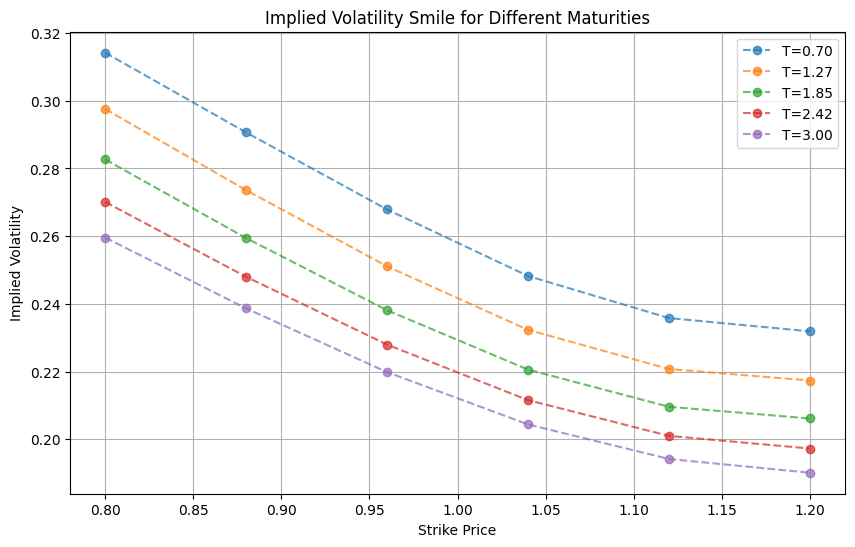

In [7]:
# Create a single figure for all maturities
plt.figure(figsize=(10, 6))

# Loop through each maturity and plot in a single figure
for i, maturity in enumerate(Maturities):
    plt.plot(Strikes, iv_call[i], label=f"T={maturity:.2f}", linestyle="dashed", marker="o", alpha=0.7)

plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile for Different Maturities")
plt.legend()
plt.grid()
plt.show()

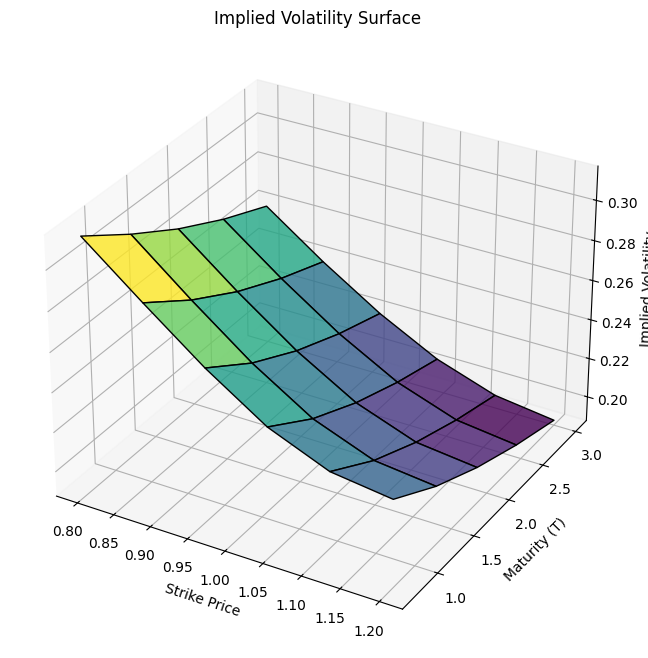

In [8]:
iv_call2=np.array(iv_call)
# Create a 3D implied volatility surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for 3D plotting
Strikes_grid, Maturities_grid = np.meshgrid(Strikes, Maturities)

# Plot the IV surface
ax.plot_surface(Strikes_grid, Maturities_grid, iv_call2, cmap='viridis', edgecolor='k', alpha=0.8)

# Labels and title
ax.set_xlabel("Strike Price")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")

plt.show()

Now here we generate the paths of the time augmented d-dimensional Brownian motion and compute the signatures associated to all of the paths.


Thanks to the way the model is defined we can do this just once and than use the same generated signature to do the Calibration Pricing without introducing any bias. This allows us to drastically reduce computation time.


Let the time-augmented 3-dimensional Brownian motion be:

$$
X_t = (t, W_t^{(1)}, W_t^{(2)}, W_t^{(3)})
$$

Here the Generated Brownian motions have cosntat correlation 

$$
\text{corr}(W^{(i)}_t, W^{(j)}_t) = \rho = -0.3 \quad \text{for all } i \ne j
$$

Then the signature of the path up to level 2 is given by:

$$
\text{Sig}(X)_{0,t}^{(2)} = \left(1, \int_0^t dX_s, \int_0^t \int_0^{s_1} dX_{s_2} \otimes dX_{s_1} \right)
$$

That is:

$$
\text{Sig}(X)_{0,t}^{(2)} = \left(1,\ X_t,\ \int_0^t X'_s \otimes X'_s\, ds\right) = \left(1,\ X_t,\ \int_0^t dX_s \otimes dX_s \right)
$$

which explicitly contains terms like:

$$
\left(1,\ t,\ W_t^{(1)}, W_t^{(2)}, W_t^{(3)},\ \int_0^t ds,\ \int_0^t W_s^{(i)}\, ds,\ \int_0^t W_s^{(i)} W_s^{(j)}\, ds,\ \dots \right)
$$



In [9]:
BM_Paths=generate_paths(Max_Maturity, N, d, num_simulations)
signatures=np.zeros((num_simulations,Num_Maturities,iisignature.siglength(d, m)))
for i in range (num_simulations):
    for j,maturity in enumerate(Maturities):
        signatures[i,j,:]=compute_signature(BM_Paths[i,:,:int(maturity*N)].T, m)

Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%


Now we calibrate the model to the syntetically generted Prices

The authors suggest calibrating the model using as a loss function the quadratic error between the Computed Prices and the Obsered price in the follwoing way:

$$
\ell \in \arg\min_{\ell} \, L_{\text{option}}(\ell),
$$

where  
$$
L_{\text{options}}(\ell) = \sum_{i=1}^{N} \gamma_i \left( C^*(T_i, K_i) - C^{\text{model}}(T_i, K_i, \ell) \right)^2.
$$

Here $\gamma_i$ are the computed Vega weights of the options.


Instead, we choose to use an alternative approach by calibrating directly to the implied volatility smile of the option. Through experimentation, we observed that this method leads to faster and more accurate convergence.

Out loss function is:

The loss function based on the implied volatility smile is defined as:

$$
L_{\text{IV}}(\ell) = \sum_{i=1}^{N} w_i \left( \sigma_{\text{market}}(T_i, K_i) - \sigma_{\text{model}}(T_i, K_i, \ell) \right)^2,
$$

where:
- $\sigma_{\text{market}}(T_i, K_i)$ is the market implied volatility for maturity $T_i$ and strike $K_i$,
- $\sigma_{\text{model}}(T_i, K_i, \ell)$ is the model-implied volatility given parameters $\ell$,



In [11]:
# Global list to track errors
error_history = []

def obj_function(l, signatures, iv_flat, x, r, Strikes, Maturities):
    global latest_l, error_history  # Declare that we are modifying the global variable
    latest_l = l  # Update the global variable with the current l

    Computed_Ivs = []
    for j, maturity in enumerate(Maturities):
        S_T = x + l.T @ signatures[:, j, :].T
        for strike in Strikes:
            Computed_Ivs.append(implied_vol_minimize(np.mean(np.maximum(S_T - strike, 0)) * np.exp(-r * maturity), x, strike, maturity, r, "call"))

    Computed_Ivs = np.array(Computed_Ivs)
    error = Computed_Ivs - iv_flat

    total_error = np.sum(error ** 2)
    
    # Store error for tracking
    error_history.append(total_error)
    
    # Clear previous output
    clear_output(wait=True)
    
    # Print current iteration, error, and l values
    print(f"Iteration: {len(error_history)}")
    print(f"Current Error: {total_error:.6f}")
    print(f"Current l:\n{l}")
    print(f"error:\n{error}")

    return total_error


In [12]:
l_initial = np.ones(iisignature.siglength(d, m))*0.01

x=1
r=0.01
res = least_squares(obj_function, l_initial, args=(signatures, iv_flat,x,r, Strikes, Maturities),
                    loss="linear",  # Linear least squares loss
                    ftol=1e-4, xtol=1e-4, gtol=1e-4)

l_optimized=res.x

Iteration: 31126
Current Error: 0.002447
Current l:
[ 0.02626981  0.15053854  0.16155804 -0.01538726  0.01971035  0.02101967
  0.01973263  0.03413617  0.00154312  0.02031405  0.0017969   0.03573742
  0.02897678 -0.01771019 -0.01879218 -0.01673306 -0.02199405  0.00107104
 -0.01870241  0.00129728 -0.02307423 -0.01748542 -0.00797816 -0.00411155
 -0.02200525  0.02358401  0.01575579  0.0009479   0.00764102  0.014987
 -0.0193384  -0.00374045 -0.00920819  0.00108243  0.01504456  0.00779547
 -0.02320198  0.01482966  0.02511952]
error:
[ 0.01563    -0.01099219 -0.02021184 -0.01977206 -0.01878123 -0.02169634
  0.00712159 -0.00032599 -0.00029558  0.00277233  0.00331669 -0.00090623
  0.00165084  0.00146034  0.00478497  0.00872107  0.00954212  0.00547365
 -0.003376   -0.0011416   0.00285358  0.00637348  0.00695835  0.00309392
 -0.00445472 -0.00301699 -0.00059996  0.00129075  0.00069089 -0.00358127]


In [14]:
l_optimized=latest_l

In [15]:
latest_l

array([ 0.02626981,  0.15053854,  0.16155804, -0.01538726,  0.01971035,
        0.02101967,  0.01973263,  0.03413617,  0.00154312,  0.02031405,
        0.0017969 ,  0.03573742,  0.02897678, -0.01771019, -0.01879218,
       -0.01673306, -0.02199405,  0.00107104, -0.01870241,  0.00129728,
       -0.02307423, -0.01748542, -0.00797816, -0.00411155, -0.02200525,
        0.02358401,  0.01575579,  0.0009479 ,  0.00764102,  0.014987  ,
       -0.0193384 , -0.00374045, -0.00920819,  0.00108243,  0.01504456,
        0.00779547, -0.02320198,  0.01482966,  0.02511952])

Finally we compute the Prices of call options with our newly generated model using MonteCarlo technique.

$
{S}_n(\ell)_t := \ell(\widehat{\mathbb{X}}_t),
$

We plot the implied volatility surface of the model with the heston one, and see the results

In [16]:
Computed_Ivs = []
temp=[]
Computed_Ivs_Separated=[]

for j, maturity in enumerate(Maturities):
    S_T = x + l_optimized.T @ signatures[:, j, :].T
    for strike in Strikes:
        Computed_Ivs.append(implied_vol_minimize(np.mean(np.maximum(S_T - strike, 0)) * np.exp(-r * maturity), x, strike, maturity, r, "call"))
        temp.append(Computed_Ivs[-1])
    Computed_Ivs_Separated.append(temp)
    temp=[]
Computed_Ivs=np.array(Computed_Ivs)  

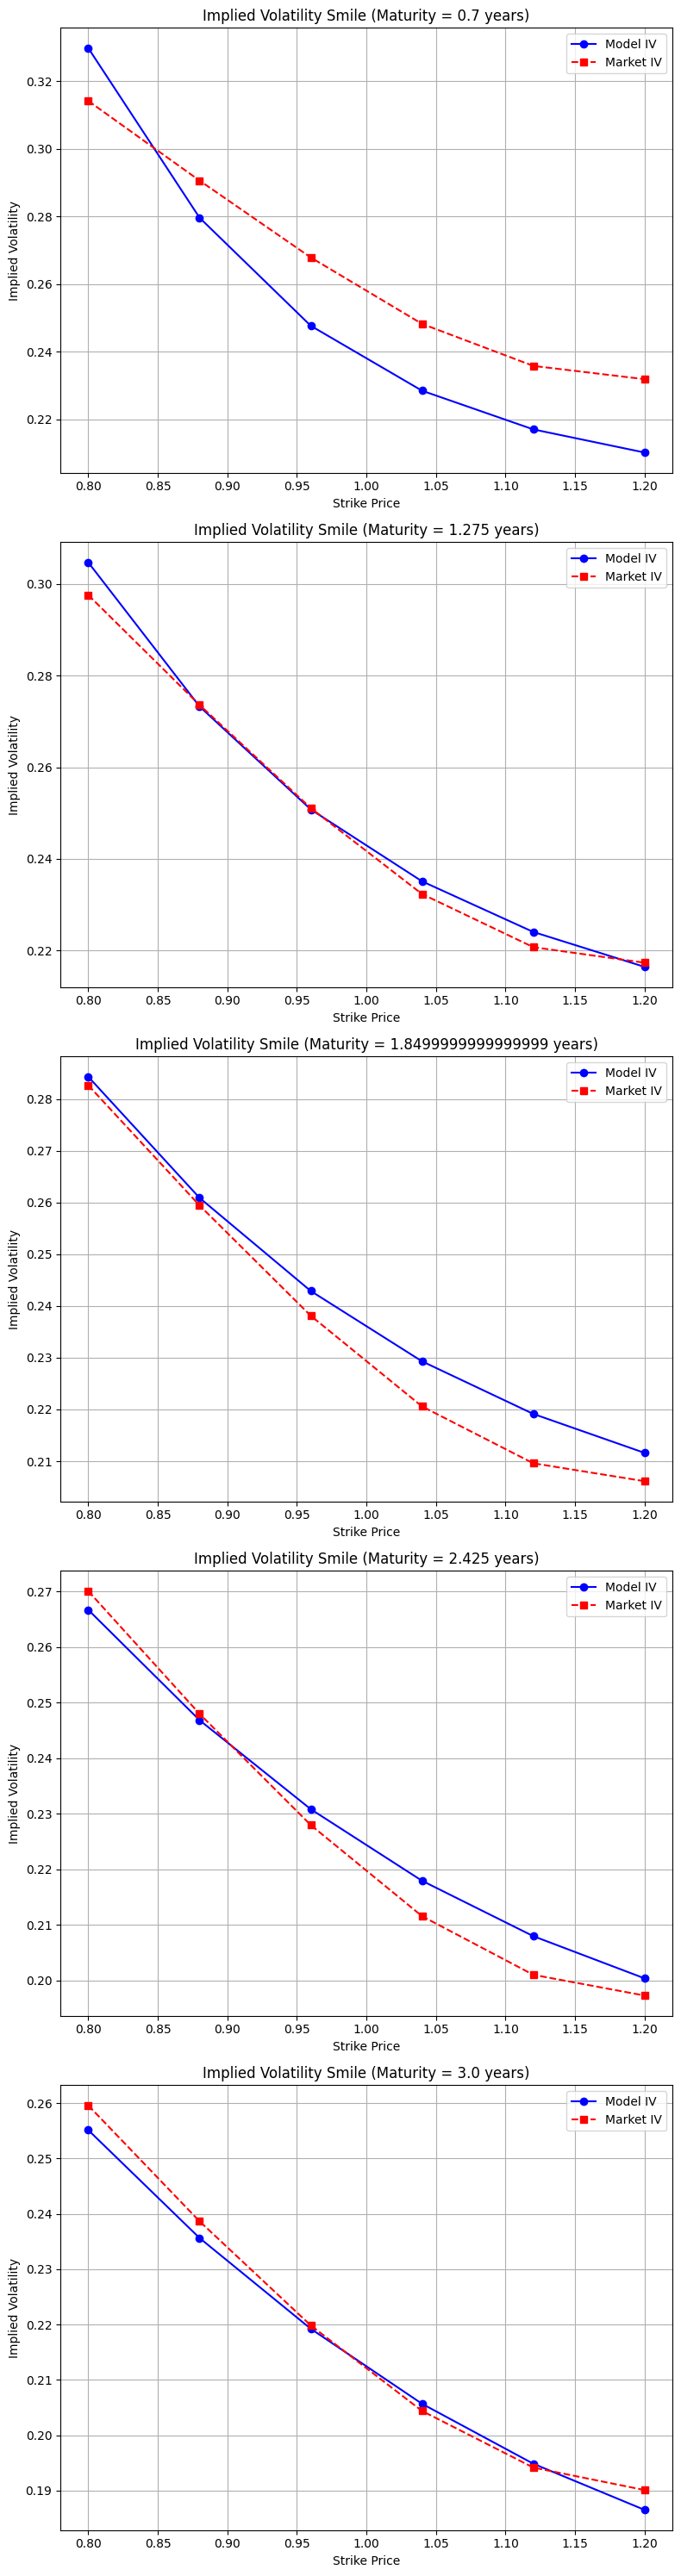

In [17]:
fig, axes = plt.subplots(len(Maturities), 1, figsize=(8, 6 * len(Maturities)))


for i, maturity in enumerate(Maturities):
    ax = axes[i]  # Select the subplot

    ax.plot(Strikes, Computed_Ivs_Separated[i], marker="o", linestyle="-", label="Model IV", color="blue")
    ax.plot(Strikes, iv_call[i], marker="s", linestyle="--", label="Market IV", color="red")

    ax.set_title(f"Implied Volatility Smile (Maturity = {maturity} years)")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.legend()
    ax.grid()


# Adjust layout for better visibility
plt.tight_layout()
plt.show()


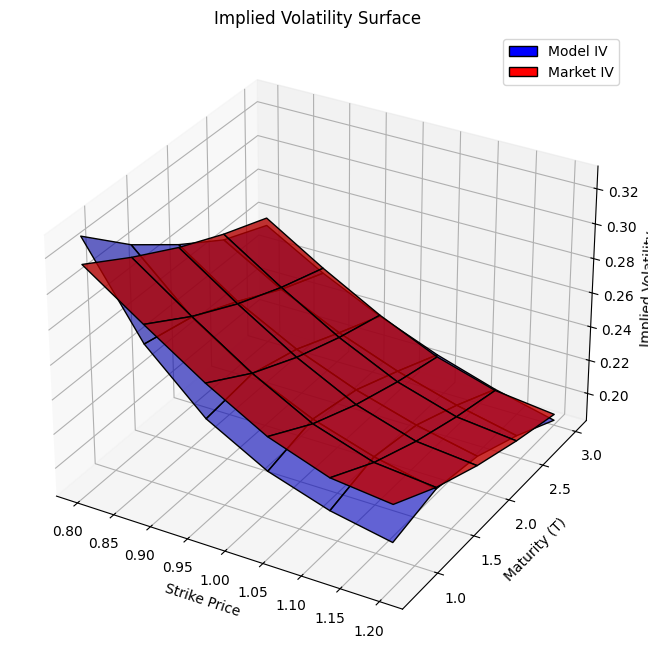

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

# Convert lists to arrays for plotting
iv_call2 = np.array(iv_call)
model_iv2 = np.array(Computed_Ivs_Separated)  # Ensure model IV data is also a NumPy array

# Create a meshgrid for 3D plotting
Strikes_grid, Maturities_grid = np.meshgrid(Strikes, Maturities)

# Create figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot Market IV surface (Solid Red)
market_surface = ax.plot_surface(Strikes_grid, Maturities_grid, iv_call2, color='red', edgecolor='k', alpha=0.8)

# Plot Model IV surface (Solid Blue)
model_surface = ax.plot_surface(Strikes_grid, Maturities_grid, model_iv2, color='blue', edgecolor='k', alpha=0.6)

# Labels and title
ax.set_xlabel("Strike Price")
ax.set_ylabel("Maturity (T)")
ax.set_zlabel("Implied Volatility")
ax.set_title("Implied Volatility Surface")

# Create a custom legend using proxy artists
legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label="Model IV"),
    Patch(facecolor='red', edgecolor='black', label="Market IV")
]

# Add the legend
ax.legend(handles=legend_elements, loc='upper right')

# Show the plot
plt.show()


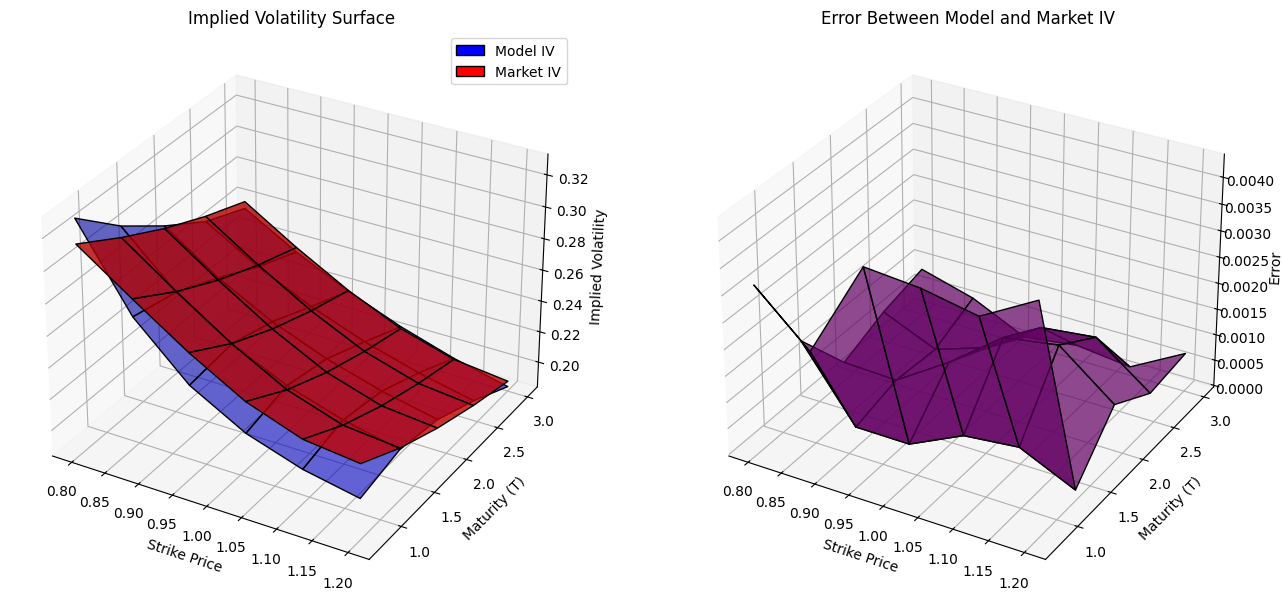

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Patch

# Convert lists to arrays for plotting
iv_call2 = np.array(iv_call)
model_iv2 = np.array(Computed_Ivs_Separated)

# Compute the absolute error
error_iv = np.abs(model_iv2 - iv_call2)

# Create a meshgrid for 3D plotting
Strikes_grid, Maturities_grid = np.meshgrid(Strikes, Maturities)

# Create figure and subplots
fig = plt.figure(figsize=(16, 8))  # Wider figure for side-by-side subplots

# ---- Left subplot: 3D IV Surface ----
ax1 = fig.add_subplot(121, projection='3d')  # 1 row, 2 cols, first subplot
ax1.plot_surface(Strikes_grid, Maturities_grid, iv_call2, color='red', edgecolor='k', alpha=0.8)
ax1.plot_surface(Strikes_grid, Maturities_grid, model_iv2, color='blue', edgecolor='k', alpha=0.6)

# Labels and title
ax1.set_xlabel("Strike Price")
ax1.set_ylabel("Maturity (T)")
ax1.set_zlabel("Implied Volatility")
ax1.set_title("Implied Volatility Surface")

# Custom legend
legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label="Model IV"),
    Patch(facecolor='red', edgecolor='black', label="Market IV")
]
ax1.legend(handles=legend_elements, loc='upper right')

# ---- Right subplot: Error plot ----
ax2 = fig.add_subplot(122, projection='3d')  # 1 row, 2 cols, second subplot
error_surface = ax2.plot_surface(Strikes_grid, Maturities_grid, error_iv/5, color='purple', edgecolor='k', alpha=0.7)

# Labels and title
ax2.set_xlabel("Strike Price")
ax2.set_ylabel("Maturity (T)")
ax2.set_zlabel("Error")
ax2.set_title("Error Between Model and Market IV")

# Show the figure
plt.show()
